In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from utils import *
from models import *
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 500

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
d = 2
m = 8
t = 200
n = 10000
snr = 0
lamda = 0.2
distance = 0.1
coherent = False

array = ULA(m, lamda)
array.build_sensor_positions(distance)
array.build_array_manifold()

In [4]:
gaps = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
methods = [
           "MUSIC(R=360)",
           "MUSIC(R=1800)", 
           "Root-MUSIC", 
           "DA-MUSIC", 
           "DA-MUSIC v2", 
           "RNN"
           ]
mean_mse = {
    "MUSIC(R=360)": [],
    "MUSIC(R=1800)": [],
    "Root-MUSIC": [],
    "DA-MUSIC": [],
    "DA-MUSIC v2": [],
    "RNN": []
}

loss_cpu = MSPE(d, 'cpu')
loss_cuda = MSPE(d, 'cuda')

path = 'saved_models/'

music_360 = MUSIC(d, array, -torch.pi/2, torch.pi/2, 360)
music_1800 = MUSIC(d, array, -torch.pi/2, torch.pi/2, 1800)
root_music = Root_MUSIC(d, array)

for gap in gaps:

    observations, angles = generate_data(n, t, d, snr, snr, array, False, coherent, gap=gap)

    # good_observations = []
    # good_angles = []
    # results_music = []
    # for i in range(observations.shape[0]):
    #     theta_est, _, good = MUSIC(observations[i].T, d, array)
    #     if good:
    #         good_observations.append(observations[i])
    #         good_angles.append(angles[i])
    #         results_music.append(theta_est)
    # observations = torch.stack(good_observations, dim=0)
    # angles = torch.stack(good_angles, dim=0)
    # results_music = torch.stack(results_music, dim=0)

    results_music_360 = []
    for i in range(observations.shape[0]):
        theta_est, _, _ = music_360.estimate(observations[i].T)
        results_music_360.append(theta_est)
    results_music_360 = torch.stack(results_music_360, dim=0)
    
    mse_music_360 = loss_cpu(results_music_360, angles)
    mean_mse['MUSIC(R=360)'].append(mse_music_360)

    results_music_1800 = []
    for i in range(observations.shape[0]):
        theta_est, _, _ = music_1800.estimate(observations[i].T)
        results_music_1800.append(theta_est)
    results_music_1800 = torch.stack(results_music_1800, dim=0)
    
    mse_music_1800 = loss_cpu(results_music_1800, angles)
    mean_mse['MUSIC(R=1800)'].append(mse_music_1800)

    results_root_music = root_music.estimate(observations)
    mse_root_music = loss_cpu(results_root_music, angles)
    mean_mse['Root-MUSIC'].append(mse_root_music)

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    da_music = DA_MUSIC(m, d, array, dev)
    mean_mse['DA-MUSIC'].append(test(da_music, test_loader, path+'da_music_'+str(snr)+'dB.pth', loss_cuda, dev))

    da_music_v2 = DA_MUSIC_v2(m, d, array, dev)
    mean_mse['DA-MUSIC v2'].append(test(da_music_v2, test_loader, path+'da_music_v2_'+str(snr)+'dB.pth', loss_cuda, dev))

    rnn = RNN(m, d, dev)
    mean_mse['RNN'].append(test(rnn, test_loader, path+'rnn_'+str(snr)+'dB.pth', loss_cuda, dev))

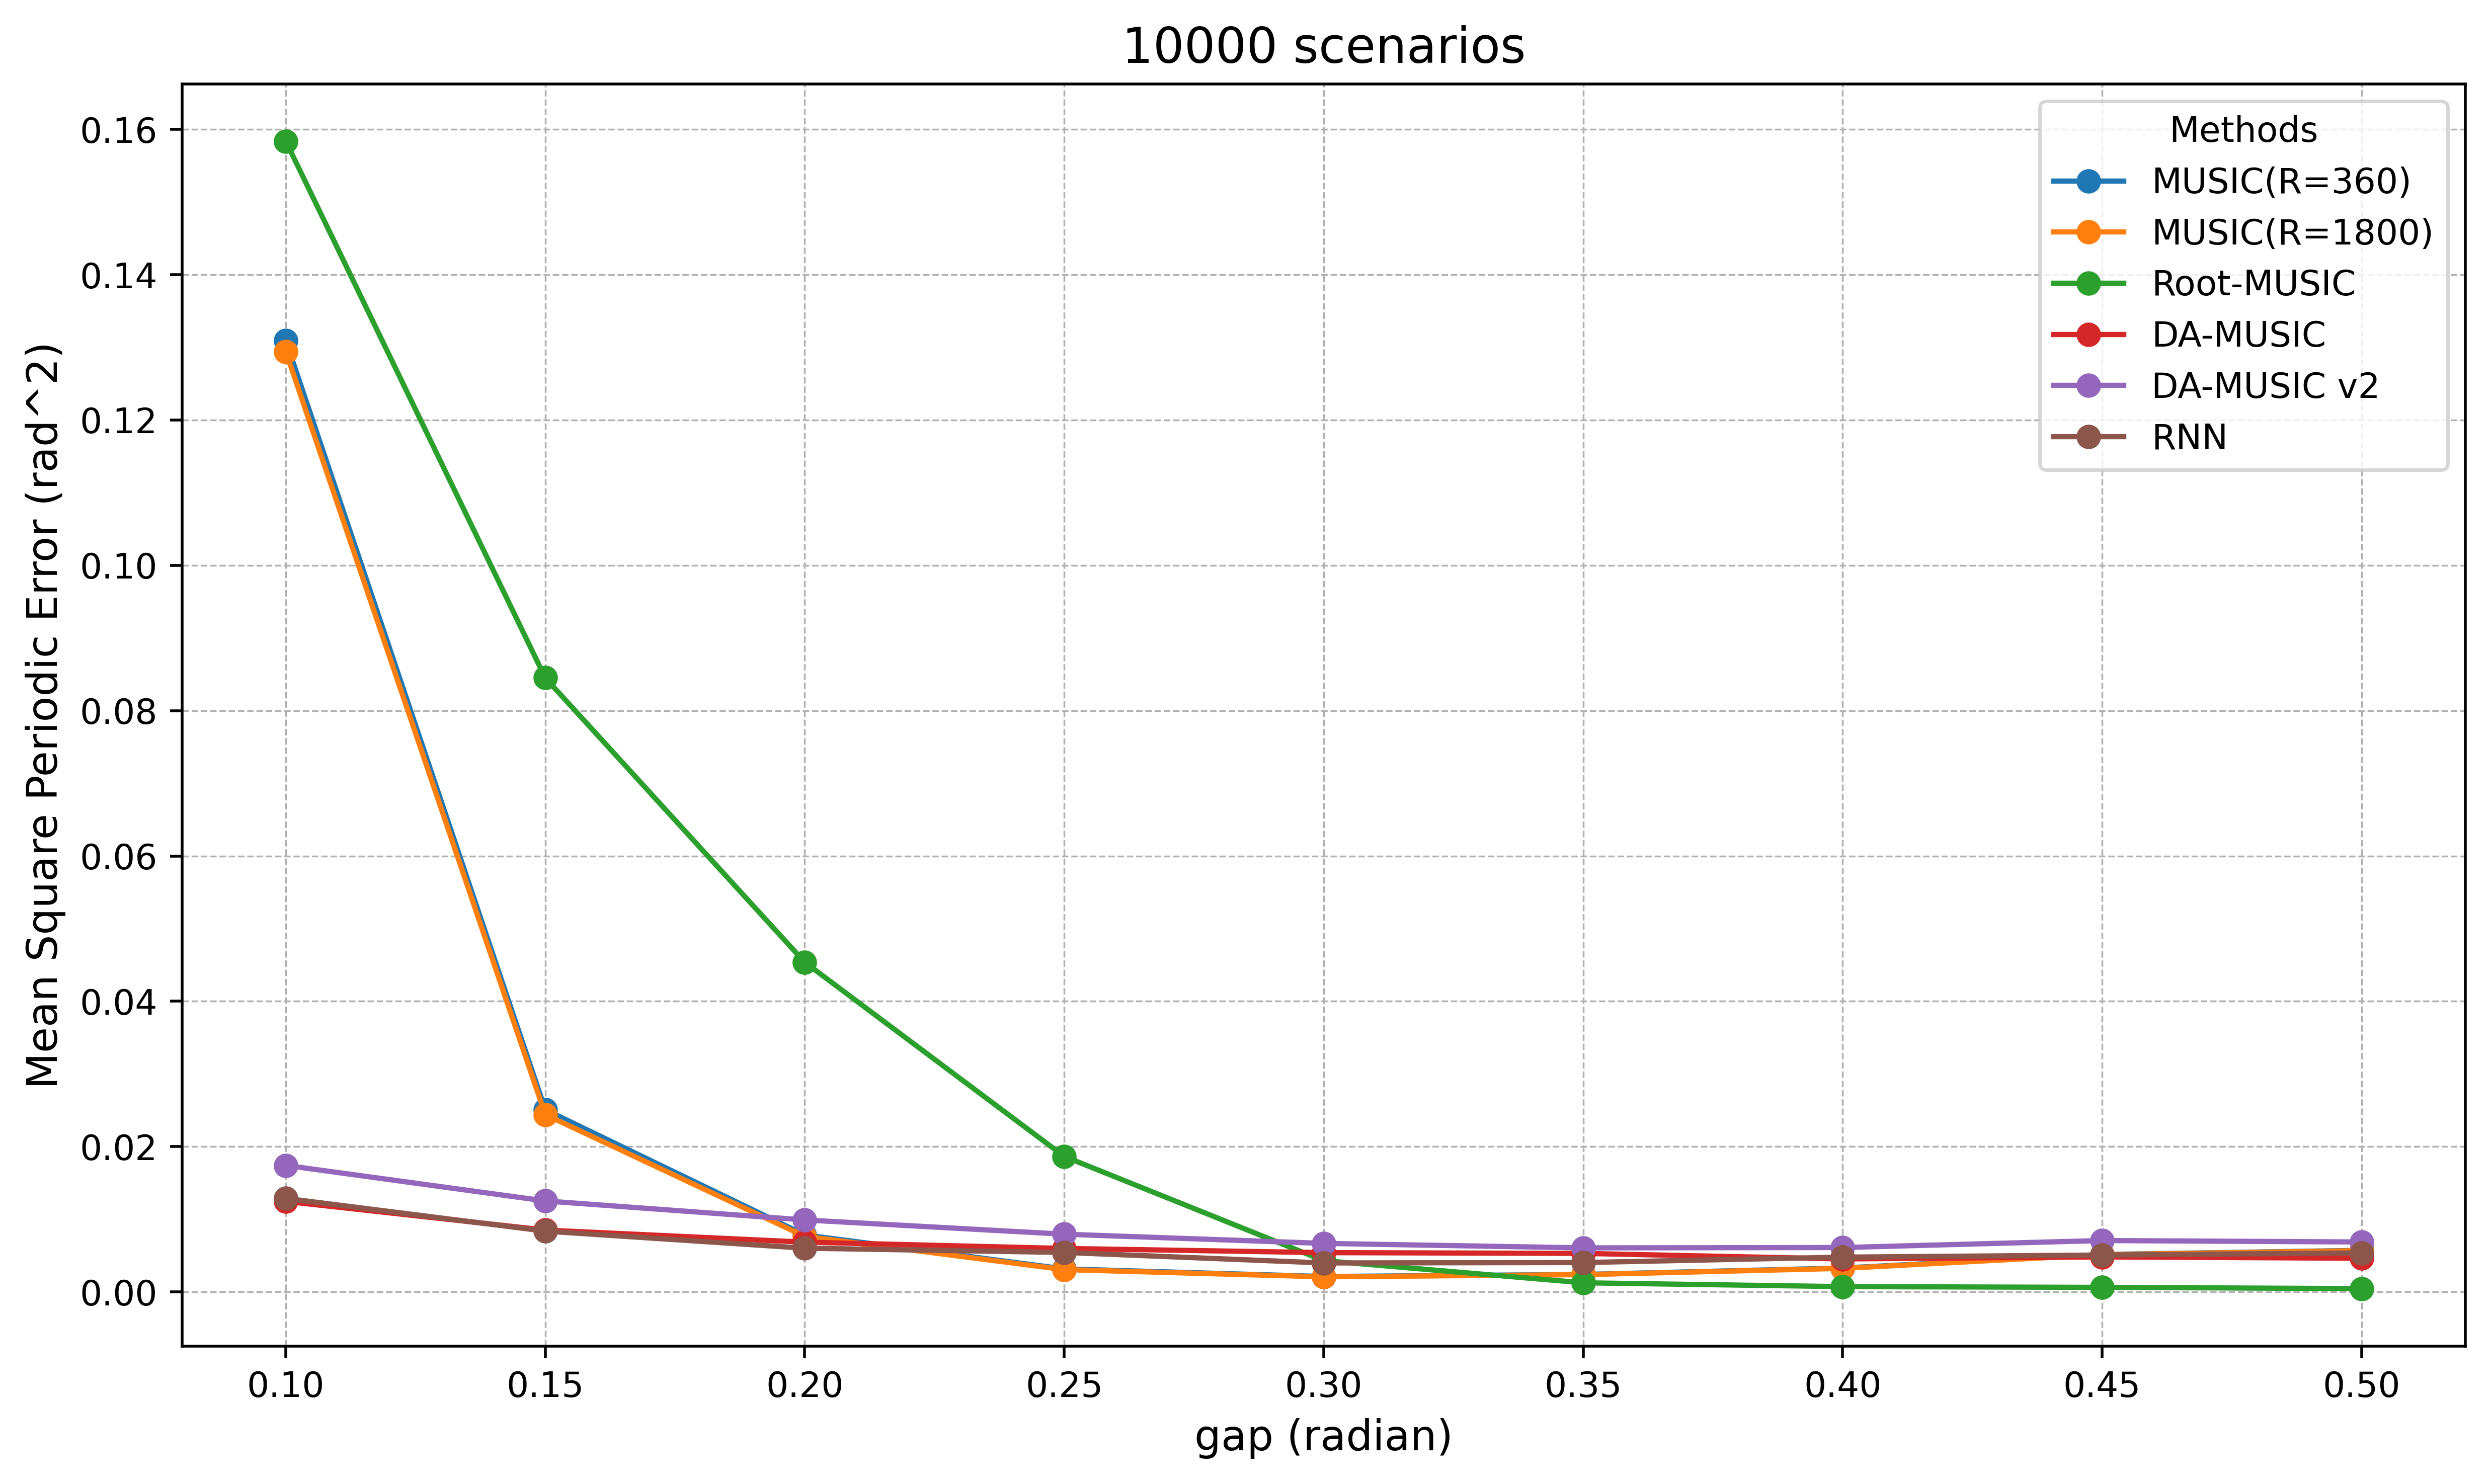

In [5]:
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(gaps, mean_mse[method], marker='o', label=method)

# plt.yscale("log")
plt.title("{} scenarios".format(n), fontsize=14)
plt.xlabel("gap (radian)", fontsize=12)
plt.ylabel("Mean Square Periodic Error (rad^2)", fontsize=12)
plt.xticks(gaps)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Methods")
plt.tight_layout()
plt.show()